In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
import optuna

# Model definitions

In [87]:
def model_0(x, w, b, lapse):
    """
    Null model: fixed slope and bias across all trials.
    """
    p = norm.cdf(w * x + b)
    return p * (1 - lapse) + 0.5 * lapse


In [88]:
def model_1(x, w, b_dict, condition, lapse):
    """
    Bias model: same slope w, different bias b by condition.
    b_dict: dictionary with condition keys (e.g., 'threat+', 'threat-') and corresponding bias values.
    """
    b = b_dict[condition]
    p = norm.cdf(w * x + b)
    return p * (1 - lapse) + 0.5 * lapse


In [89]:
def model_2(x, w_dict, b, condition, lapse):
    """
    Sensitivity model: same bias b, different slope w by condition.
    w_dict: dictionary with condition keys and corresponding slope values.
    """
    w = w_dict[condition]
    p = norm.cdf(w * x + b)
    return p * (1 - lapse) + 0.5 * lapse


In [7]:
def loss(model_choices, real_choices):
    """
    Loss function: sum of squared differences between model choices and real choices.
    """
    return np.sum((np.array(model_choices) - np.array(real_choices)) ** 2)

In [8]:
def log_likelihood(model_probs, real_choices):
    """
    Log-likelihood function: sum of log probabilities of the model choices.
    """
    return np.sum(np.log(model_probs) * np.array(real_choices) + np.log(1 - model_probs) * (1 - np.array(real_choices)))

# Sim

In [90]:
# Parameters

n_trials = 100
x = np.random.randint(-7, 8, size=n_trials)
z = np.random.choice(['threat+', 'threat-'], size=n_trials)
correct_responses = [(lambda x: 1 if x > 0 else 0)(x) for x in x]

In [91]:
model_zero_params = {
    'w': 0.6,
    'b': 0.9,
    'lapse': 0.05
}
model_one_params = {
    'w': 0.5,
    'b_dict': {'threat+': 0.5, 'threat-': -0.5},
    'lapse': 0.05
}
model_two_params = {
    'w_dict': {'threat+': 0.75, 'threat-': 0.25},
    'b': 0.75,
    'lapse': 0.05
}

In [92]:
x

array([ 2, -4, -2,  1,  1,  4,  1,  0, -5, -3, -1,  0,  5, -1,  4,  7,  3,
       -2,  5, -4, -1, -4,  2, -6,  7,  6,  7,  1,  4,  0, -5,  6, -7,  3,
        2,  2, -1, -5,  0, -2, -1, -4,  4,  3, -3,  1,  7, -6, -1,  4,  4,
        3,  0,  0,  3,  5, -5, -4, -3,  1, -7,  3, -3, -5, -4, -6, -7,  0,
       -4,  4, -7,  5,  0,  2, -5, -5,  2,  2,  2,  5,  1, -1, -1,  4, -6,
        2, -6,  5,  5,  5, -2,  7, -4, -2,  2, -5,  2,  0,  6,  3])

In [93]:
probs = []
for y in range(n_trials):
    condition = z[y]

    # Model 0: fixed parameters
    p_zero = model_0(x[y], model_zero_params['w'], model_zero_params['b'], model_zero_params['lapse'])

    # Model 1: bias depends on condition
    p_one = model_1(x[y], model_one_params['w'], model_one_params['b_dict'], condition, model_one_params['lapse'])

    # Model 2: slope depends on condition
    p_two = model_2(x[y], model_two_params['w_dict'], model_two_params['b'], condition, model_two_params['lapse'])

    probs.append((p_zero, p_one, p_two))

In [119]:
model_zero_probs = np.array(probs)[:, 0]
model_zero_choice = np.random.binomial(1, model_zero_probs)

In [120]:
model_one_probs = np.array(probs)[:, 1]
model_one_choice = np.random.binomial(1, model_one_probs)


In [121]:
model_two_probs = np.array(probs)[:, 2]
model_two_choice = np.random.binomial(1, model_two_probs)

In [122]:
model_two_choice

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1])

In [123]:
model_one_choice == model_two_choice

array([ True,  True,  True, False, False,  True,  True,  True,  True,
       False,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True, False,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True])

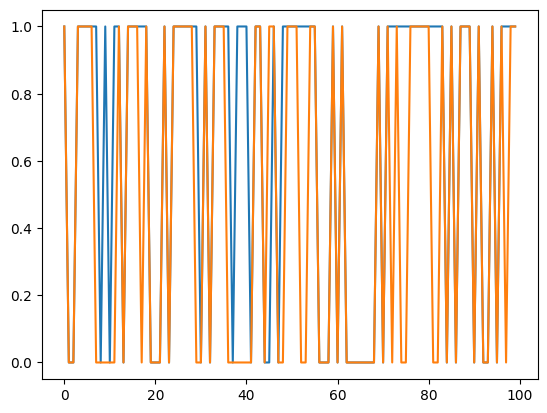

In [124]:
plt.plot(model_two_choice)
plt.plot(correct_responses)

In [125]:
print(loss(model_zero_choice, correct_responses))
print(loss(model_one_choice, correct_responses))
print(loss(model_two_choice, correct_responses))

20
15
19


In [126]:
log_likelihood_zero = log_likelihood(model_zero_probs, correct_responses)
log_likelihood_one = log_likelihood(model_one_probs, correct_responses)
log_likelihood_two = log_likelihood(model_two_probs, correct_responses)

In [127]:
print("Log-likelihood for model 0:", log_likelihood_zero)
print("Log-likelihood for model 1:", log_likelihood_one)
print("Log-likelihood for model 2:", log_likelihood_two)

Log-likelihood for model 0: -28.67598299757203
Log-likelihood for model 1: -17.680279484251447
Log-likelihood for model 2: -34.31041442969433


# Parameter Recovery

In [129]:
def fit_model(stim_values, observed_choices, conditions, model_num, n_trials=100):
    """
    Unified model fitter for models 0, 1, and 2
    
    Parameters:
    - stim_values: face stimuli (-7 to +7)
    - observed_choices: binary choices from the model we're trying to fit
    - conditions: array of condition labels ('threat+', 'threat-')
    - model_num: which model to fit (0, 1, or 2)
    """
    observed_choices = np.array(observed_choices)
    def objective(trial):
        # Common parameters
        lapse = trial.suggest_float('lapse', 0.0, 0.05)
        
        if model_num == 0:
            # Model 0: single w and b
            w = trial.suggest_float('w', 0.01, 5.0)
            b = trial.suggest_float('b', -2.0, 2.0)
            pred_probs = model_0(stim_values, w, b, lapse)
            
        elif model_num == 1:
            # Model 1: single w, condition-dependent b
            w = trial.suggest_float('w', 0.01, 5.0)
            b_plus = trial.suggest_float('b_plus', -2.0, 2.0)
            b_minus = trial.suggest_float('b_minus', -2.0, 2.0)
            b_dict = {'threat+': b_plus, 'threat-': b_minus}
            
            pred_probs = []
            for x_i, cond in zip(stim_values, conditions):
                p = model_1(x_i, w, b_dict, cond, lapse)
                pred_probs.append(p)
            pred_probs = np.array(pred_probs)
            
        elif model_num == 2:
            # Model 2: condition-dependent w, single b
            w_plus = trial.suggest_float('w_plus', 0.01, 5.0)
            w_minus = trial.suggest_float('w_minus', 0.01, 5.0)
            b = trial.suggest_float('b', -2.0, 2.0)
            w_dict = {'threat+': w_plus, 'threat-': w_minus}
            
            pred_probs = []
            for x_i, cond in zip(stim_values, conditions):
                p = model_2(x_i, w_dict, b, cond, lapse)
                pred_probs.append(p)
            pred_probs = np.array(pred_probs)
        
        eps = 1e-9  # to avoid log(0)
        p = np.clip(pred_probs, eps, 1 - eps)
        nll = -np.sum(observed_choices * np.log(p) + (1 - observed_choices) * np.log(1 - p))
        return nll

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

In [132]:
params0 = fit_model(x, model_zero_choice, z, model_num=0)
params1 = fit_model(x, model_one_choice, z, model_num=1)
params2 = fit_model(x, model_two_choice, z, model_num=2)

[I 2025-05-16 17:03:13,881] A new study created in memory with name: no-name-f52feb3b-7c54-483e-8821-935aa2f6a2b9
[I 2025-05-16 17:03:13,908] Trial 0 finished with value: 55.46396477824668 and parameters: {'lapse': 0.004163222459314148, 'w': 2.343011092868174, 'b': 0.902076529199475}. Best is trial 0 with value: 55.46396477824668.
[I 2025-05-16 17:03:13,910] Trial 1 finished with value: 28.782522009595603 and parameters: {'lapse': 0.035082717956347556, 'w': 0.854072286309362, 'b': 1.0643615847239176}. Best is trial 1 with value: 28.782522009595603.
[I 2025-05-16 17:03:13,916] Trial 2 finished with value: 33.6854386536965 and parameters: {'lapse': 0.03567909532653544, 'w': 2.037078006496919, 'b': 1.9301848609852073}. Best is trial 1 with value: 28.782522009595603.
[I 2025-05-16 17:03:13,921] Trial 3 finished with value: 78.1626033401212 and parameters: {'lapse': 0.0010436994298421488, 'w': 4.622987899277546, 'b': 1.6614914989569898}. Best is trial 1 with value: 28.782522009595603.
[I 20

[I 2025-05-16 17:03:13,960] Trial 9 finished with value: 97.67558460066128 and parameters: {'lapse': 0.002239593165248077, 'w': 0.9724081642545267, 'b': -1.5833737632425824}. Best is trial 1 with value: 28.782522009595603.
[I 2025-05-16 17:03:14,018] Trial 10 finished with value: 70.76064813216217 and parameters: {'lapse': 0.016403321709128036, 'w': 3.223780587946286, 'b': -1.1551279763585574}. Best is trial 1 with value: 28.782522009595603.
[I 2025-05-16 17:03:14,040] Trial 11 finished with value: 34.77633862351459 and parameters: {'lapse': 0.03299952413990133, 'w': 1.3750910090665522, 'b': 0.863719033969967}. Best is trial 1 with value: 28.782522009595603.
[I 2025-05-16 17:03:14,051] Trial 12 finished with value: 47.59144889644141 and parameters: {'lapse': 0.030091638079303023, 'w': 0.12954108094190842, 'b': 0.8797168377720277}. Best is trial 1 with value: 28.782522009595603.
[I 2025-05-16 17:03:14,060] Trial 13 finished with value: 42.57734549425541 and parameters: {'lapse': 0.04023

In [134]:
print(f"True: w={model_zero_params['w']}, b={model_zero_params['b']}, lapse={model_zero_params['lapse']}")
print(f"Recovered: {params0}\n")
print(f"True: w={model_one_params['w']}, b_dict={model_one_params['b_dict']}, lapse={model_one_params['lapse']}")
print(f"Recovered: {params1}\n")
print(f"True: w_dict={model_two_params['w_dict']}, b={model_two_params['b']}, lapse={model_two_params['lapse']}")
print(f"Recovered: {params2}")

True: w=0.6, b=0.9, lapse=0.05
Recovered: {'lapse': 0.049018985665642216, 'w': 0.6787177358714003, 'b': 1.0994390214055718}

True: w=0.5, b_dict={'threat+': 0.5, 'threat-': -0.5}, lapse=0.05
Recovered: {'lapse': 0.023943349528872632, 'w': 0.4100578839834371, 'b_plus': 0.9843035930417917, 'b_minus': 0.05615582853291316}

True: w_dict={'threat+': 0.75, 'threat-': 0.25}, b=0.75, lapse=0.05
Recovered: {'lapse': 0.031565920325934874, 'w_plus': 0.7542986139260446, 'w_minus': 0.4861183051255897, 'b': 1.0259377819263116}
